In [43]:
from SMOOTH import *
from BLOCKS import *
from MIXED import *
from KERNEL import *
from TKV_REG import *
from GCV import *
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)

In [12]:
"""FILE = "presentation_signals.csv"
# sigs = open(FILE, 'r')
# This is here as a way to reinitialize with good signals.
sigs = open(FILE, 'w')
for i in smooth:
    sigs.write(f"{i},")
sigs.write('\n')
for i in blocked:
    sigs.write(f"{i},")
sigs.write('\n')
for i in combined:
    sigs.write(f"{i},")
sigs.close()"""

In [12]:
FILE = "presentation_signals.csv"
sigs = open(FILE, 'r')
smooth = sigs.readline()
blocked = sigs.readline()
combined = sigs.readline()
sigs.close()
smooth = smooth.split(',')
blocked = blocked.split(',')
combined = combined.split(',')
smooth = [float(i) for i in smooth]
blocked = [float(i) for i in blocked]
combined = [float(i) for i in combined]

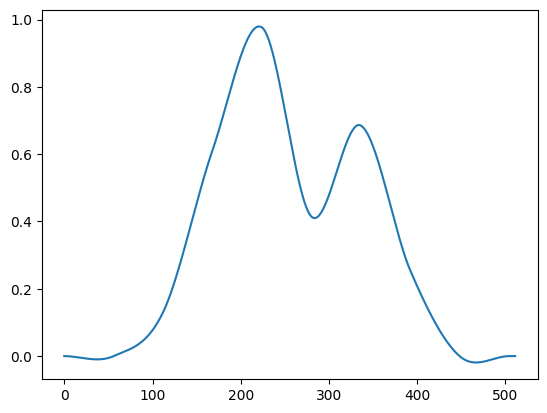

In [4]:
plt.plot(smooth)
plt.show()
#plt.savefig('./figures/smooth.png', dpi=300)

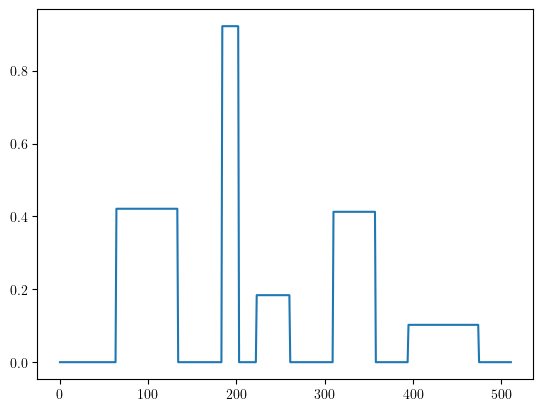

In [13]:
plt.plot(blocked)
plt.show()
#plt.savefig('./figures/blocked.png', dpi=300)

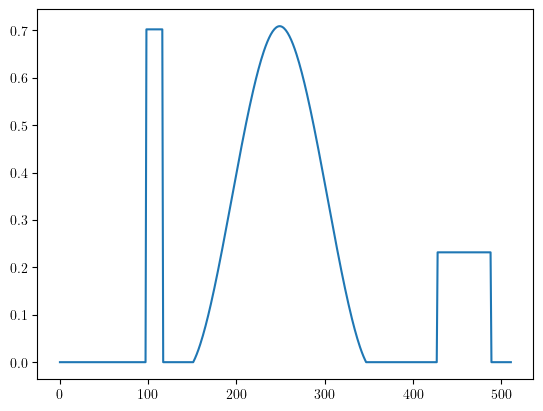

In [14]:
plt.plot(combined)
plt.show()
#plt.savefig('./figures/combined.png', dpi=300)

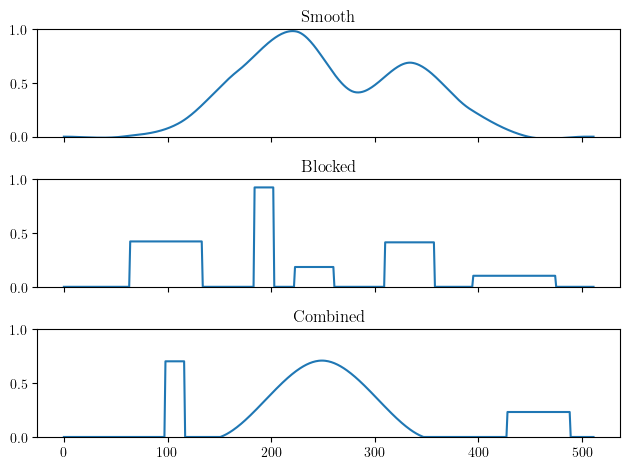

In [15]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex='col')
ax0.plot(smooth)
ax0.set_ylim(0,1)
ax0.set_title("Smooth")

ax1.plot(blocked)
ax1.set_ylim(0,1)
ax1.set_title("Blocked")

ax2.plot(combined)
ax2.set_ylim(0,1)
ax2.set_title("Combined")

plt.tight_layout()
#plt.show()
plt.savefig('./figures/subplots.png', dpi=300)

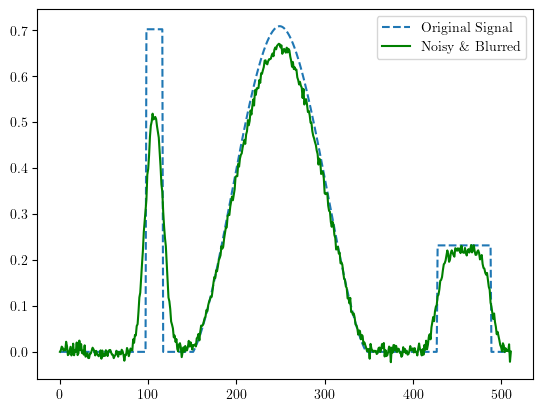

In [16]:
from BLUR import *
from KERNEL import *

x = np.asarray(combined)
A = kernel(len(combined), 8)
blurred = blur(x, A, True, 0.008)

plt.plot(x, '--')
plt.plot(blurred, 'g')
plt.legend(["Original Signal", r"Noisy \& Blurred"])
plt.show()
#plt.savefig('./figures/blurred.png', dpi=300)

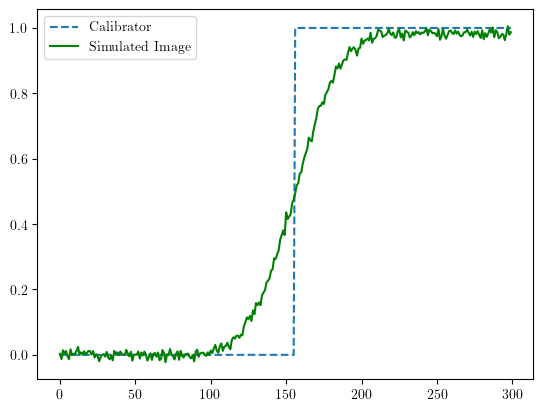

In [17]:
calib_x = []
for i in range(512):
    if i < 256:
        calib_x.append(0.)
    else:
        calib_x.append(1.)
calib_x = np.asarray(calib_x).reshape(len(calib_x), 1)
calib_A = kernel(calib_x.shape[0], 24)
calib_blurred = blur(calib_x, calib_A, True, 0.01)

plt.plot(calib_x[100:400], '--')
plt.plot(calib_blurred[100:400], 'g')
plt.legend(["Calibrator", "Simulated Image"])
plt.show()
#plt.savefig('./figures/blurrededge.png', dpi=300)

In [20]:
from statistics import mean
from math import exp
from scipy.special import erf

def diff(sig, s):
    d = np.zeros(s)
    for i in range(s):
        if i == 0 or i == s-1:
            d[i] = 0
        else:
            d[i] = (sig[i+1] - sig[i-1]) / 2.
    return d

def normalize_diff(sig):
    s = sum(sig)*2
    return [i / s for i in sig]

def normalize_edge(sig):
    l = len(sig)
    v = sig[l-l//8:]
    p = mean(v)
    return [i / p for i in sig]

def find_index(val, ls):
    i = 0
    for j in ls:
        if j == val:
            return i
        else:
            i += 1
    return 0

# Define curve functions to fit

def logistic(k, le):
    y = []
    x0 = le // 2
    for x in range(le):
        v = 1 / (1 + exp(-k * (x - x0)))
        y.append(v)
    return y

def use_erf(a, le):
    y = []
    x0 = le // 2
    for x in range(le):
        y.append(0.5 * (1 + erf(a*(x-x0))))
    return y

def find_mse(orig, new):
    return mean((a - b)*(a - b) for a, b in zip(orig, new))

In [21]:
cropped_x = calib_blurred[150:512-150]
cropped_x = cropped_x.transpose()
cropped_x = cropped_x[0]
norm_x = normalize_edge(cropped_x)
n = 512
k = [np.random.random() for i in range(n)]
mses = [find_mse(norm_x, use_erf(term, len(norm_x))) for term in k]
m = find_index(min(mses), mses)

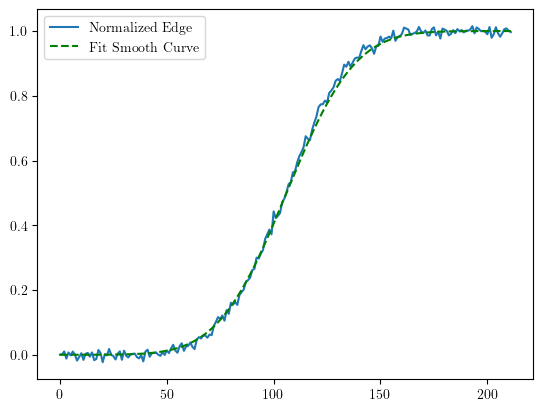

In [22]:
plt.plot(norm_x)
plt.plot(use_erf(k[m], len(norm_x)), 'g--')
plt.legend(["Normalized Edge", "Fit Smooth Curve"])
plt.show()
#plt.savefig('./figures/fitcurve.png')

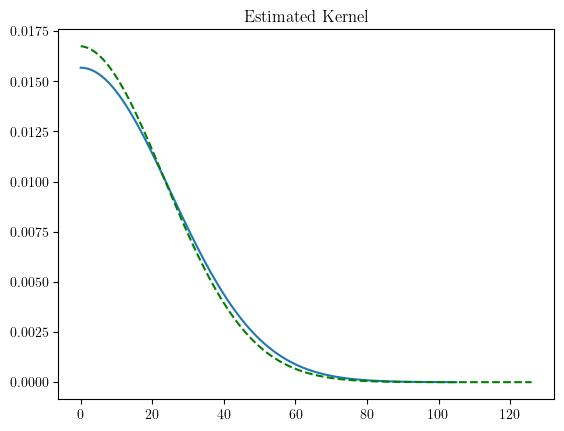

In [23]:
diff_calib_x = diff(use_erf(k[m], len(norm_x)), len(norm_x))
diff_calib_x = normalize_diff(diff_calib_x[len(norm_x)//2:])
plt.plot(diff_calib_x)

meep = np.diff(st.norm.cdf(np.linspace(0, 128/24, 128)))
meep = meep / sum(meep) / 2
plt.plot(meep, 'g--')
plt.title("Estimated Kernel")
plt.show()
#plt.savefig('./figures/kernel.png', dpi=300)

In [24]:
print(sum(diff_calib_x))

0.4999999999999995


In [25]:
A = generateBlurMatrix(len(calib_x), diff_calib_x)
tester = smooth

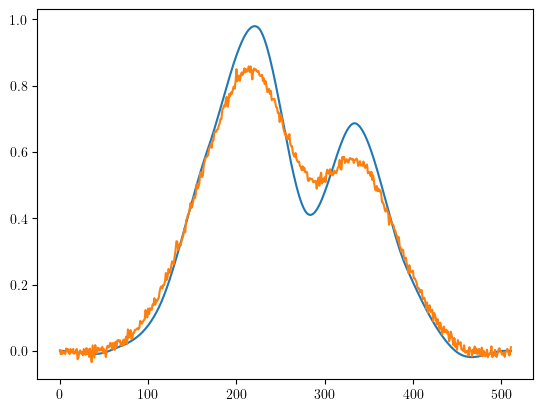

In [26]:
test = blur(np.array(tester).reshape((512, 1)), calib_A, True, 0.01)
plt.plot(tester)
plt.plot(test)
plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

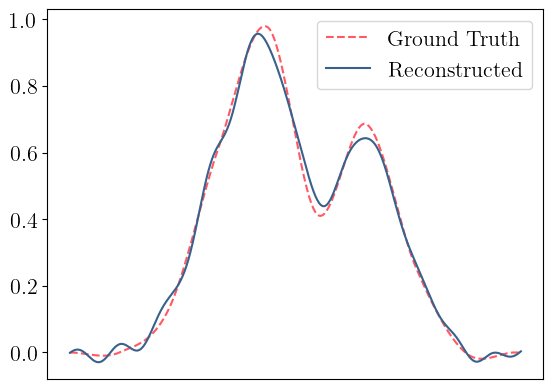

In [44]:
toggleDebug(-1)
reconstructed, gcv = run_gcv(A, test, tkv_regularize, 4)

#plt.plot(test)
plt.plot(tester, '--', color=(1, 89/255, 100/255))
plt.plot(reconstructed, color=(56/255, 97/255, 140/255))
plt.legend(["Ground Truth", "Reconstructed"])
plt.tick_params(left = True, right = False , labelleft = True ,
                labelbottom = False, bottom = False)
plt.savefig('./figures/TKV.png', dpi=300, transparent=True)

In [46]:
qualifiedBlur = []
#mmse = 2. * min(mses)
mmse = min(mses) * 10
for i in range(len(mses)):
    if mses[i] <= mmse:
        qualifiedBlur.append([mses[i], k[i]])

In [47]:
plots = []
for i in qualifiedBlur:
    fit = use_erf(i[1], len(tester))
    diffFit = diff(fit, len(tester))
    diffFit = normalize_diff(diffFit[len(tester)//2:])
    A = generateBlurMatrix(len(tester), diffFit)
    out, err = run_gcv(A, test, tkv_regularize, 8)
    plots.append(out)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

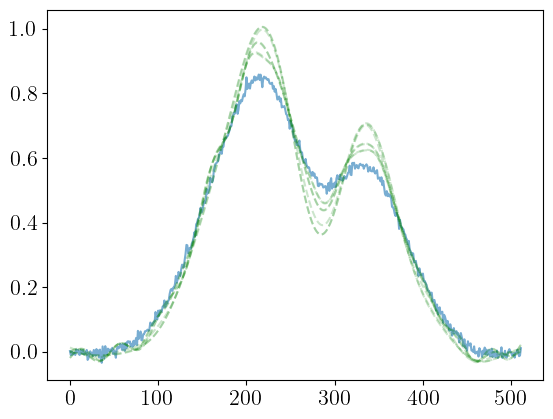

In [48]:
plt.plot(test, alpha=0.6)
for p in plots:
    plt.plot(p, 'g--', alpha=0.2)
plt.show()

In [49]:
from TV_REG import *

A = kernel(512, 10)
tv_test = np.asarray(blocked)
tv_test = blur(tv_test.reshape(512,1), A, True, 0.007)

In [50]:
toggleDebug(1)
reconstructed, gcv = run_gcv(A, tv_test, tv_regularize, 3)

  0%|          | 0/30 [00:00<?, ?it/s]

RuntimeError: latex was not able to process the following string:
b'GCV(\\\\alpha)'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../48953b1e6cbe922807a56a6349d96297.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 48953b1e6cbe922807a56a6349d96297.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily GCV(\alpha
                          )}
No pages of output.
Transcript written on 48953b1e6cbe922807a56a6349d96297.log.




<Figure size 640x480 with 1 Axes>

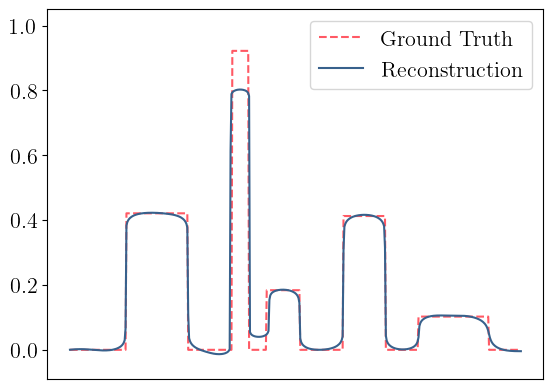

In [56]:
plt.plot(blocked, '--', color=(1, 89/255, 100/255))
plt.plot(reconstructed, color=(56/255, 97/255, 140/255))

plt.ylim(-0.09, 1.05)
plt.legend(["Ground Truth", "Reconstruction"])
plt.tick_params(left = True, right = False , labelleft = True ,
                labelbottom = False, bottom = False)
#plt.show()
plt.savefig('./figures/TV.png', dpi=300, transparent=True)

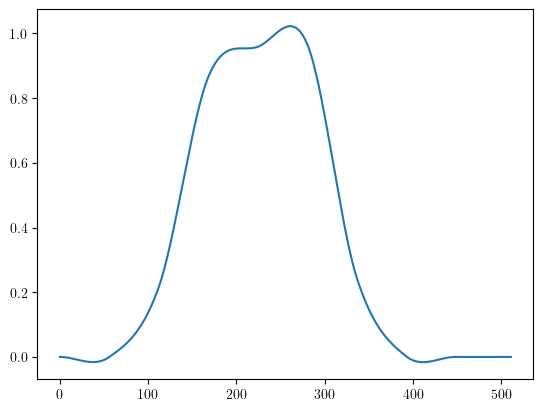

In [45]:
smooth = generate_smooth_signal()
plt.plot(smooth)
plt.show()

In [46]:
tkv_test = np.asarray(smooth)
tkv_test = blur(tkv_test.reshape(512,1), A, True, 0.007)
toggleDebug(-1)
reconstructed, gcv = run_gcv(A, tkv_test, tkv_regularize, 4)

  0%|          | 0/40 [00:00<?, ?it/s]

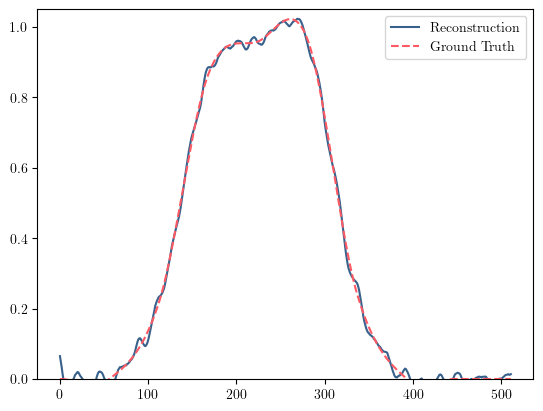

In [48]:
plt.plot(reconstructed, color=(56/255, 97/255, 140/255))
plt.plot(smooth, '--', color=(1, 89/255, 100/255))
plt.ylim(0, 1.05)
plt.legend(["Reconstruction", "Ground Truth"])
#plt.show()
plt.savefig('./figures/TKV.png', dpi=300, transparent=True)